In [1]:
from datetime import datetime
import gc
import random
import os
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelBinarizer
import lightgbm as lgb
import numpy as np
from tqdm import tqdm
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
# from catboost import CatBoostRegressor
from matplotlib import pyplot
from numba import jit
from time import time
from tqdm import tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import imblearn.over_sampling as imb_sample
import json
import warnings        
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 1000)
np.random.seed(42)
random.seed(42)
input_path = '../input/'
df_columns = ['region','city','eventbody','eventname','eventtime','lat','lgt','nettype','title','uadevice','uaos','userid','date'
]

In [2]:
def read_train_data():
    s = datetime.now()
    df_0 = pd.read_csv(input_path+'train1541/tps_training_dataset_2_text/000000_0', sep='\001',header=None)
    df_0.columns = df_columns
    df_1 = pd.read_csv(input_path+'train1541/tps_training_dataset_2_text/000001_0', sep='\001',header=None)
    df_1.columns = df_columns
    df_2 = pd.read_csv(input_path+'train1541/tps_training_dataset_2_text/000002_0', sep='\001',header=None)
    df_2.columns = df_columns
    df_3 = pd.read_csv(input_path+'train1541/tps_training_dataset_2_text/000003_0', sep='\001',header=None)
    df_3.columns = df_columns
    df = pd.concat([df_0,df_1], axis = 0)
    del df_0
    del df_1
    gc.collect()
    df = pd.concat([df,df_2], axis = 0)
    del df_2
    gc.collect()
    df = pd.concat([df,df_3], axis = 0)
    del df_3
    gc.collect()
    print ('time:{}'.format(datetime.now()-s))
    return df
train_data = read_train_data()

time:0:00:36.420699


In [3]:
test_data = pd.read_csv(input_path+'test5469/000000_0', sep='\001',header=None)
test_data.columns = df_columns

In [4]:
train_data = train_data.sort_values(by='eventtime').reset_index()
test_data = test_data.sort_values(by='eventtime').reset_index()

In [5]:
train_data.head()

,index,region,city,eventbody,eventname,eventtime,lat,lgt,nettype,title,uadevice,uaos,userid,date
0,282986,广东,广州,productNameE生平安·百万医url_startTime15856702176...,h320057,1585670516069,23.1167,113.25,wifi,E生平安·百万医,COL-AL10,Android,67457021,20200401
1,283006,广东,广州,productNameE生平安·百万医url_startTime15856702176...,HCZ_H00016530,1585670516315,23.1167,113.25,wifi,E生平安·百万医,COL-AL10,Android,67457021,20200401
2,199079,广东,珠海市,eventLabel点击“保险”dockuid6686331渠道App Store...,11010479,1585670516839,22.2769,113.568,Wifi,\N,iPhone X,iOS,6686331,20200401
3,282813,广东,广州,eventLabel新非车险首页货架-点击健康position3city揭阳ui...,329000022,1585670525910,23.1167,113.25,wifi,非车险首页,COL-AL10,Android,67457021,20200401
4,282818,广东,广州,eventLabel进入货架列表页position2city揭阳uid6745...,329000029,1585670526230,23.1167,113.25,wifi,平安保险,COL-AL10,Android,67457021,20200401


In [6]:
print(f'train_data.userid: {len(train_data.userid.unique())}')
print(f'test_data.userid: {len(test_data.userid.unique())}')
print(f'union:{set(train_data.userid)&set(test_data.userid)}')

train_data.userid: 16144
test_data.userid: 4714
union:set()


In [7]:
print(f'train date:{train_data.date.min()}-{train_data.date.max()}')
print(f'test date:{test_data.date.min()}-{test_data.date.max()}')

train date:20200401-20200430
test date:20200401-20200420


In [8]:
def get_label(x):
# x.split('\x02')[6].split('\x03')[1] if len(x.split('\x02'))>=7 and len(x.split('\x02')[3].split('\x03'))>=2 else 0
    lb = 0
    dic = x.split('\x02')
    if len(dic)>=7 and len(dic[3].split('\x03'))>=2:
        lb_tmp = dic[6].split('\x03')[1]
        if 15>len(lb_tmp)>10 and lb_tmp.isnumeric():
            lb = lb_tmp
    return lb

def get_hzc(x):
    hzc=0
    dic = x.split('\x02')
    if len(dic)>=4 and len(dic[3].split('\x03'))>=2:
        hzc_tmp = dic[3].split('\x03')[1]
        if hzc_tmp.startswith('hczoi_'):
            hzc = hzc_tmp
    return hzc

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s))

In [9]:
train_data['hzcModule'] = train_data['eventbody'].apply(get_hzc)
train_data['productId'] = train_data['eventbody'].apply(get_label)
test_data['hzcModule'] = test_data['eventbody'].apply(get_hzc)
test_data['productId'] = test_data['eventbody'].apply(get_label)

In [10]:
product_id_train = list(set(train_data['productId'])-set([0]))
product_id_test = list(set(test_data['productId'])-set([0]))
print(len(product_id_train),len(product_id_test))
product_id_all = list(set(product_id_train)|set(product_id_test))
print(len(product_id_all))
# encode_product_id = {name:f'product_id_{i}' for i,name in enumerate(product_id_all)}
encode_product_id = {name:name for i,name in enumerate(product_id_all)}
decode_product_id = {name:name for i,name in enumerate(product_id_all)}
train_data['productId'] = train_data['productId'].apply(lambda x: encode_product_id[x] if x!=0 else 0)
test_data['productId'] = test_data['productId'].apply(lambda x: encode_product_id[x] if x!=0 else 0)

121 101
128


In [11]:
title_list = list(set(train_data['title'])|set(set(test_data['title'])))
encode_title = {name:f'title_{str(i).zfill(3)}' for i,name in enumerate(title_list)}
decode_title = {f'title_{str(i).zfill(3)}':name for i,name in enumerate(title_list)}
train_data['title'] = train_data['title'].apply(lambda x:encode_title[x])
test_data['title'] = test_data['title'].apply(lambda x:encode_title[x])
train_encode_title = list(set(train_data['title']))

In [12]:
uaos_list = list(set(train_data['uaos'])|set(set(test_data['uaos'])))
encode_uaos = {name:i for i,name in enumerate(uaos_list)}
decode_uaos = {i:name for i,name in enumerate(uaos_list)}

In [13]:
nettype_list = list(set(train_data['nettype'])|set(set(test_data['nettype'])))
encode_nettype = {name:i for i,name in enumerate(nettype_list)}
decode_nettype = {i:name for i,name in enumerate(nettype_list)}

In [14]:
train_data_y = train_data[train_data['date'] >= 20200421]
product_id_y = train_data_y[(train_data_y.eventname=='h320057')&(train_data_y.hzcModule.isin (['hczoi_good_best','hczoi_good_accident','hczoi_good_fitness','hczoi_good_trip','hczoi_good_estate','hczoi_good_company','hczoi_good_special']))]['productId'].unique()
len(product_id_y)

62

In [15]:
pinyin2zhongwen = {'Shijiazhuang':'石家庄', 'Shantou':'汕头', 'Putian':'莆田', 'Zhangjiagang':'张家港', 'Guangdong':'广州', 'Hejin':'河津', 'Feicheng':'费城', 'Suqian':'宿迁','Yongjiawan':'永嘉', 'Dongyang':'东阳','Xinyang':'信阳', 'Nanyang':'南阳', 'Yan\'an':'延安', 'Guli':'南京', 'Huainan':'淮南','Hezhou':'贺州', 'Laiyang':'莱阳', 'Linyi':'临沂', 'Fuzhoushi':'福州', 'Suicheng':'遂城', 'Chuxiong':'楚雄', 'Changzhi':'长治','Changshu City':'常熟', 'Kaiyuan':'开原', 'Haimen':'海门', 'Xushan':'徐山', 'Guizhoumanzuxiang':'贵州', 'Kunyang':'昆阳', 'Qinghai':'青海', 'Sanya':'三亚', 'Wuzhong':'苏州', 'Hanchuan':'汉川', 'Sichuan':'成都', 'Gaomi':'高密', 'Xinjiang':'新疆', 'Taichung':'台中', 'Hanzhong':'汉中', 'Dongtai':'东台', 'Guixi':'贵溪', 'Wamrong':'不丹', 'Xinan':'新安', 'Hainan':'海口', 'Yushu':'玉树', 'Chencun':'顺德', 'Chengxiang':'莆田', 'Daqing':'大庆', 'Xiantao':'仙桃', 'Xiabancheng':'承德', 'Yaocheng':'太原', 'Tianya':'三亚', 'Yaluhu':'雅路', 'Yangcun':'杨村', 'Shenzhou':'深州', 'Weitang':'苏州', 'Henan':'开封', 'Yuncheng':'郓城', 'Yongcheng':'永城', "Li'an":'黎安', 'Dongcun':'成都', 'Fuqing':'福清', 'Shangzhou':'商州', 'Xiaoshan':'萧山', 'Bazhou':'霸州', 'Changle':'福州', 'Zhuozhou':'涿州', 'Hechi':'河池', 'Beijing':'北京', 'Daye':'大冶', 'Yicheng':'宜城', "Gu'an":'廊坊', 'Rugao':'如皋', 'Shuozhou':'朔州', 'Central District':'西雅图', 'Jiaozhou':'胶州', 'Sheyang':'盐城', 'Meizhou':'梅州', 'Yongji':'永济', 'Zhangshu':'樟树', 'Nusajaya':'马来西亚', 'Xuhui':'上海'}



In [16]:
def convert_city(x):
    c_x = x
    if x[-1]=='市':
        c_x = x[:-1]
    elif x in pinyin2zhongwen.keys():
        c_x = pinyin2zhongwen[x]
    return c_x

train_data['city'] = train_data['city'].apply(convert_city)
train_data['city']

0          广州
1          广州
2          珠海
3          广州
4          广州
           ..
2435914    东营
2435915    东营
2435916    东营
2435917    东营
2435918    东营
Name: city, Length: 2435919, dtype: object

In [17]:
first_citys = ['北京', '上海', '广州', '深圳', '天津']
second_citys = ['南京', '武汉', '沈阳', '西安', '成都', '重庆', '杭州', '青岛', '大连', '宁波', '济南', '哈尔滨', '长春', '厦门', '郑州', '长沙', '福州', '乌鲁木齐', '昆明', '兰州', '苏州', '无锡']
third_citys = ['南昌','贵阳','南宁','合肥','太原','石家庄','呼和浩特','佛山','东莞','鞍山','唐山','泉州','银川','西宁','海口','洛阳','南通','常州','徐州','潍坊','淄博','绍兴','温州','台州','大庆','中山','珠海','汕头','吉林','柳州','拉萨','保定','邯郸','秦皇岛','沧州','鄂尔多斯','东营','威海','济宁','临沂','德州','滨州','泰安','湖州','嘉兴','金华','泰州','镇江','盐城','扬州','桂林','惠州','湛江','江门','茂名','株洲','岳阳','衡阳','宝鸡','宜昌','襄樊','开封','许昌','平顶山','赣州','九江','芜湖','绵阳','齐齐哈尔','牡丹江','抚顺','本溪','丹东','辽阳','锦州','营口','承德','廊坊','邢台','大同','榆林','延安','天水','克拉玛依','喀什','石河子','南阳','濮阳','安阳','焦作','新乡','日照','聊城','枣庄','蚌埠','淮南','马鞍山','连云港','淮安','丽水','衢州','荆州','安庆','景德镇','新余','湘潭','常德','郴州','漳州','清远','揭阳','梅州','肇庆','玉林','北海','德阳','宜宾','遵义','大理']
city_dict = dict()
for i in first_citys:
    city_dict[i] = 1
for i in second_citys:
    city_dict[i] = 2
for i in third_citys:
    city_dict[i] = 3
train_data['city_sort'] = train_data['city'].apply(lambda x: city_dict[x] if x in city_dict.keys() else 4)
test_data['city_sort'] = test_data['city'].apply(lambda x: city_dict[x] if x in city_dict.keys() else 4)
train_data['city_sort'].head()

0    1
1    1
2    3
3    1
4    1
Name: city_sort, dtype: int64

In [18]:
label_names = [decode_product_id[y] for y in product_id_y]

In [19]:
train_data.head()

,index,region,city,eventbody,eventname,eventtime,lat,lgt,nettype,title,uadevice,uaos,userid,date,hzcModule,productId,city_sort
0,282986,广东,广州,productNameE生平安·百万医url_startTime15856702176...,h320057,1585670516069,23.1167,113.25,wifi,title_094,COL-AL10,Android,67457021,20200401,hczoi_good_fitness,2020010375676,1
1,283006,广东,广州,productNameE生平安·百万医url_startTime15856702176...,HCZ_H00016530,1585670516315,23.1167,113.25,wifi,title_094,COL-AL10,Android,67457021,20200401,hczoi_good_fitness,2020010375676,1
2,199079,广东,珠海,eventLabel点击“保险”dockuid6686331渠道App Store...,11010479,1585670516839,22.2769,113.568,Wifi,title_069,iPhone X,iOS,6686331,20200401,0,0,3
3,282813,广东,广州,eventLabel新非车险首页货架-点击健康position3city揭阳ui...,329000022,1585670525910,23.1167,113.25,wifi,title_093,COL-AL10,Android,67457021,20200401,0,0,1
4,282818,广东,广州,eventLabel进入货架列表页position2city揭阳uid6745...,329000029,1585670526230,23.1167,113.25,wifi,title_191,COL-AL10,Android,67457021,20200401,0,0,1


In [20]:
def onehot_cat(data, colname, drop=True):
    data = pd.concat([data,pd.get_dummies(data[f'{colname}'], prefix=f'{colname}')],axis=1)
    data.drop(columns=[f'{colname}'],inplace=drop)
    return data

In [21]:
def get_data_gb(data, is_train=True):
    data_x = data[data['date']<20200421]
    feat = pd.DataFrame({'userid':data_x.userid.unique()})
    if is_train:
        data_y = data[data['date']>=20200421]
        data_label_has = data_y[(data_y.eventname=='h320057')&(data_y.hzcModule.isin (['hczoi_good_best','hczoi_good_accident','hczoi_good_fitness','hczoi_good_trip','hczoi_good_estate','hczoi_good_company','hczoi_good_special']))][['userid','productId']].groupby(['userid'])['productId'].unique().reset_index()
        # return data_label_has
        feat_label = data_label_has.rename(columns={'productId':'label'})
        feat = feat.merge(feat_label, how='left', on='userid')
        
    ever_buy_gb = data_x[(data_x.eventname=='h320057')&(data_x.hzcModule.isin (['hczoi_good_best','hczoi_good_accident','hczoi_good_fitness','hczoi_good_trip','hczoi_good_estate','hczoi_good_company','hczoi_good_special']))][['userid','productId','date', 'hzcModule', 'title']].groupby(['userid'])
    ever_buy = ever_buy_gb['productId'].unique().reset_index()
    eb_title = ever_buy_gb['title'].apply(list).reset_index()

    eb_title['title_decode'] = eb_title['title'].apply(lambda x:[decode_title[i] for i in x])
    eb_title['accident_eb_cnt'] = eb_title['title_decode'].apply(lambda x: len([i for i in x if i[-3:-1]=='意外']))
    eb_title['shanghai_eb_cnt'] = eb_title['title_decode'].apply(lambda x: len([i for i in x if i[:2]=='上海']))
    eb_title['travel_eb_cnt'] = eb_title['title_decode'].apply(lambda x: len([i for i in x if i[2:4]=='旅游']))
    eb_title['safe_eb_cnt'] = eb_title['title_decode'].apply(lambda x: len([i for i in x if i[:4]=='平安守护']))
    eb_title['pet_eb_cnt'] = eb_title['title_decode'].apply(lambda x: len([i for i in x if i[:4]=='平安萌宠' or i[:2]=='萌宠']))
    eb_title['home_eb_cnt'] = eb_title['title_decode'].apply(lambda x: len([i for i in x if i[:4]=='平安逸家']))
    eb_title['child_eb_cnt'] = eb_title['title_decode'].apply(lambda x: len([i for i in x if i[:2]=='少儿' or i[:4]=='平安少儿']))
    eb_title['women_eb_cnt'] = eb_title['title_decode'].apply(lambda x: len([i for i in x if ('女' in i) or ('母' in i)]))
    eb_title['car_eb_cnt'] = eb_title['title_decode'].apply(lambda x: len([i for i in x if ('车' in i) or ('驾' in i)]))
    all_title_list = ['title_001', 'title_002', 'title_003', 'title_011', 'title_018', 'title_032', 'title_038', 'title_042', 'title_047', 'title_048', 'title_053', 'title_055', 'title_059', 'title_060', 'title_064', 'title_072', 'title_078', 'title_085', 'title_092', 'title_100', 'title_106', 'title_115', 'title_118', 'title_124', 'title_125', 'title_129', 'title_135', 'title_136', 'title_138', 'title_141', 'title_150', 'title_151', 'title_154', 'title_181', 'title_185', 'title_188', 'title_195', 'title_200', 'title_202', 'title_212', 'title_221', 'title_227', 'title_234', 'title_252', 'title_254', 'title_257', 'title_263', 'title_270', 'title_287', 'title_290', 'title_293', 'title_295', 'title_296', 'title_308', 'title_312', 'title_317', 'title_325', 'title_326', 'title_332', 'title_333']
    for atl in all_title_list:
        eb_title[atl+'_cnt'] = eb_title['title'].apply(lambda x: x.count(atl))
    eb_title.pop('title')
    eb_title.pop('title_decode')

    ever_buy_type_cnt = ever_buy_gb['hzcModule']

    ever_buy_type_cnt_list = ever_buy_type_cnt.apply(list).reset_index()
    need_type = ['hczoi_good_best','hczoi_good_accident','hczoi_good_fitness','hczoi_good_trip','hczoi_good_estate','hczoi_good_company','hczoi_good_special']
    for nt in need_type:
        ever_buy_type_cnt_list['ever_buy_type_'+nt+'_cnt'] = ever_buy_type_cnt_list['hzcModule'].apply(lambda x: x.count(nt))
    ever_buy_type_cnt_list.pop('hzcModule')

    ever_buy_day_min = ever_buy_gb['date'].min().reset_index()
    ever_buy_day_max = ever_buy_gb['date'].max().reset_index()
    # print(ever_buy_day_max)
    ever_buy_day_min.rename(columns={'date':'ever_buy_day_min'}, inplace=True)
    ever_buy_day_max.rename(columns={'date':'ever_buy_day_max'}, inplace=True)
    ever_buy.rename(columns={'productId':'ever_buy'}, inplace=True)
    ever_buy['ever_buy_cnt'] = ever_buy['ever_buy'].apply(lambda x:len(x))
    feat = feat.merge(ever_buy, how='left', on='userid')
    feat = feat.merge(ever_buy_day_min, how='left', on='userid')
    feat = feat.merge(ever_buy_day_max, how='left', on='userid')
    feat = feat.merge(ever_buy_type_cnt_list, how='left', on='userid')
    feat = feat.merge(eb_title, how='left', on='userid')

    feat['ever_buy_day_min'] = feat['ever_buy_day_min'].apply(lambda x : int(str(int(x))[-2:]) if not np.isnan(x) else np.nan)
    feat['ever_buy_day_max'] = feat['ever_buy_day_max'].apply(lambda x : int(str(int(x))[-2:]) if not np.isnan(x) else np.nan)
    city_sort = data_x[['userid','city_sort']].groupby(['userid'])['city_sort'].unique().reset_index()
    feat = feat.merge(city_sort, how='left', on='userid')

    # data_x['nettype'] = data_x['nettype'].apply(lambda x:'wifi' if x=='Wifi' else x)
    # # data_x['nettype'] = data_x['nettype'].apply(lambda x:x if x in ['wifi', '4G'] else 'other_net')
    # data_x['uaos'] = data_x['uaos'].apply(lambda x:'Win' if x[:3]=='Win' else x)

    # uaos_df = (data_x[['userid','uaos','eventtime']].groupby(['userid','uaos']).count()).reset_index()
    # # return uaos_df
    # uaos_df = (uaos_df.sort_values(by = ['userid','uaos'] ,ascending =['asc','asc']))
    # uaos_df.drop_duplicates('userid', keep='last', inplace=True)
    # uaos_df.rename(columns={'uaos':'uaos_mode'}, inplace=True)
    # # uaos_df['uaos_mode'] = uaos_df['uaos_mode'].apply(lambda x: int(encode_uaos[x]))
    # feat = feat.merge(uaos_df[['userid','uaos_mode']], how='left', on='userid')
    # feat = onehot_cat(feat, 'uaos_mode')

    # nettype_df = (data_x[['userid','nettype','eventtime']].groupby(['userid','nettype']).count()).reset_index()
    # nettype_df = (nettype_df.sort_values(by = ['userid','nettype'] ,ascending =['asc','asc']))
    # nettype_df.drop_duplicates('userid', keep='last', inplace=True)
    # nettype_df.rename(columns={'nettype':'nettype_mode'}, inplace=True)
    # # nettype_df['nettype_mode'] = nettype_df['nettype_mode'].apply(lambda x: int(encode_nettype[x]))
    # feat = feat.merge(nettype_df[['userid','nettype_mode']], how='left', on='userid')
    # feat = onehot_cat(feat, 'nettype_mode')

    # feat['nettype_mode'] = feat['nettype_mode'].astype(int)
    # cat_col = ['region', 'nettype', 'uaos', 'title']
    # cat_col = ['nettype', 'uaos', 'title']
    cat_col = ['title']
    for cc in cat_col:
        cc_unique = data_x[['userid',cc]].groupby('userid')[cc].unique().reset_index()
        cc_unique[cc+'_cnt'] = cc_unique[cc].apply(lambda x:len(x))
        cc_unique.rename(columns={cc:cc+'_list'}, inplace=True)
        feat = feat.merge(cc_unique, how='left', on='userid')
    return feat

In [22]:
len(train_data['userid'].unique())

16144

In [23]:
reduce_train = get_data_gb(train_data)
reduce_train.head()

,userid,label,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_001_cnt,title_002_cnt,title_003_cnt,title_011_cnt,title_018_cnt,title_032_cnt,title_038_cnt,title_042_cnt,title_047_cnt,title_048_cnt,title_053_cnt,title_055_cnt,title_059_cnt,title_060_cnt,title_064_cnt,title_072_cnt,title_078_cnt,title_085_cnt,title_092_cnt,title_100_cnt,title_106_cnt,title_115_cnt,title_118_cnt,title_124_cnt,title_125_cnt,title_129_cnt,title_135_cnt,title_136_cnt,title_138_cnt,title_141_cnt,title_150_cnt,title_151_cnt,title_154_cnt,title_181_cnt,title_185_cnt,title_188_cnt,title_195_cnt,title_200_cnt,title_202_cnt,title_212_cnt,title_221_cnt,title_227_cnt,title_234_cnt,title_252_cnt,title_254_cnt,title_257_cnt,title_263_cnt,title_270_cnt,title_287_cnt,title_290_cnt,title_293_cnt,title_295_cnt,title_296_cnt,title_308_cnt,title_312_cnt,title_317_cnt,title_325_cnt,title_326_cnt,title_332_cnt,title_333_cnt,city_sort,title_list,title_cnt
0,67457021,"[20200407796159, 20180531184230, 2019081585677...","[2020010375676, 20200309387999]",2.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1, 3]","[title_094, title_093, title_191, title_127, t...",7
1,6686331,[20180531263676],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[3, 1, 4]","[title_069, title_093, title_206, title_183, t...",19
2,66972452,"[20200407796159, 20200218174314, 2020030938799...","[20180531390867, 2020010375676, 20200218174314...",16.0,1.0,20.0,14.0,1.0,29.0,0.0,4.0,2.0,0.0,6.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1, 3]","[title_069, title_093, title_160, title_257, t...",41
3,514138,"[20180530244125, 20180531390867, 2018101036141...","[20191219138527, 20190222546822, 2020022815278...",16.0,1.0,20.0,11.0,2.0,25.0,3.0,9.0,17.0,0.0,4.0,0.0,3.0,2.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,"[1, 3]","[title_093, title_191, title_312, title_257, t...",45
4,58328216,[20200407796159],"[2020010375676, 20200309387999]",2.0,1.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[3],"[title_111, title_093, title_191, title_094, t...",8


In [24]:
# all_title_list = ['title_001', 'title_002', 'title_003', 'title_011', 'title_018', 'title_032', 'title_038', 'title_042', 'title_047', 'title_048', 'title_053', 'title_055', 'title_059', 'title_060', 'title_064', 'title_072', 'title_078', 'title_085', 'title_092', 'title_100', 'title_106', 'title_115', 'title_118', 'title_124', 'title_125', 'title_129', 'title_135', 'title_136', 'title_138', 'title_141', 'title_150', 'title_151', 'title_154', 'title_181', 'title_185', 'title_188', 'title_195', 'title_200', 'title_202', 'title_212', 'title_221', 'title_227', 'title_234', 'title_252', 'title_254', 'title_257', 'title_263', 'title_270', 'title_287', 'title_290', 'title_293', 'title_295', 'title_296', 'title_308', 'title_312', 'title_317', 'title_325', 'title_326', 'title_332', 'title_333']
# for atl in all_title_list:
#     eb_title[atl+'_cnt'] = eb_title['title'].apply(lambda x: x.count(atl))
# # eb_title.pop('title')
# eb_title.head()

In [25]:
# one_hot_cols = ['city_sort','ever_buy','region_list','nettype_list','uaos_list','title_list']
# one_hot_cols = ['city_sort','ever_buy','nettype_list','uaos_list','title_list']
one_hot_cols = ['city_sort','ever_buy','title_list']
mlbs = [MultiLabelBinarizer() for i in one_hot_cols]
for i, ohc in enumerate(one_hot_cols):
    mask = reduce_train[ohc].notnull()
    onehot_array = mlbs[i].fit_transform(reduce_train.loc[mask, ohc].dropna())
    # print(mlbs[i].classes_)
    onehot_df = pd.DataFrame(onehot_array, index=reduce_train.index[mask], columns=[ohc+'_'+str(x) for x in mlbs[i].classes_]).reindex(reduce_train.index, fill_value=0)
    reduce_train = pd.concat([reduce_train, onehot_df],axis=1)
    if ohc!='ever_buy':
        reduce_train.drop(columns=[ohc],inplace=True)
reduce_train.head()

,userid,label,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_001_cnt,title_002_cnt,title_003_cnt,title_011_cnt,title_018_cnt,title_032_cnt,title_038_cnt,title_042_cnt,title_047_cnt,title_048_cnt,title_053_cnt,title_055_cnt,title_059_cnt,title_060_cnt,title_064_cnt,title_072_cnt,title_078_cnt,title_085_cnt,title_092_cnt,title_100_cnt,title_106_cnt,title_115_cnt,title_118_cnt,title_124_cnt,title_125_cnt,title_129_cnt,title_135_cnt,title_136_cnt,title_138_cnt,title_141_cnt,title_150_cnt,title_151_cnt,title_154_cnt,title_181_cnt,title_185_cnt,title_188_cnt,title_195_cnt,title_200_cnt,title_202_cnt,title_212_cnt,title_221_cnt,title_227_cnt,title_234_cnt,title_252_cnt,title_254_cnt,title_257_cnt,title_263_cnt,title_270_cnt,title_287_cnt,title_290_cnt,title_293_cnt,title_295_cnt,title_296_cnt,title_308_cnt,title_312_cnt,title_317_cnt,title_325_cnt,title_326_cnt,title_332_cnt,title_333_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190129511511,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190425661320,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191017809362,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191209181376,ever_buy_20191219138527,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_20200221398853,ever_buy_2020022175979,ever_buy_20200224494367,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,title_list_title_000,title_list_title_001,title_list_title_003,title_list_title_004,title_list_title_006,title_list_title_008,title_list_title_010,title_list_title_011,title_list_title_012,title_list_title_013,title_list_title_014,title_list_title_016,title_list_title_017,title_list_title_018,title_list_title_019,title_list_title_020,title_list_title_022,title_list_title_024,title_list_title_025,title_list_title_026,title_list_title_027,title_list_title_028,title_list_title_030,title_list_title_031,title_list_title_032,title_list_title_033,title_list_title_034,title_list_title_035,title_list_title_036,title_list_title_037,title_list_title_038,title_list_title_039,title_list_title_040,title_list_title_041,title_list_title_043,title_list_title_044,title_list_title_045,title_list_title_046,title_list_title_047,title_list_title_048,title_list_title_050,title_list_title_051,title_list_title_052,title_list_title_054,title_list_title_056,title_list_title_057,title_list_title_060,title_list_title_062,title_list_title_063,title_list_title_067,title_list_title_068,title_list_title_069,title_list_title_071,title_list_title_072,title_list_title_073,title_list_title_074,title_list_title_075,title_list_title_077,title_li

In [26]:
eb20 = [i for i in reduce_train.columns if i[11:13]=='20']
eb19 = [i for i in reduce_train.columns if i[11:13]=='19']
eb18 = [i for i in reduce_train.columns if i[11:13]=='18']
def get_ever_buy_year_cnt(data):
    data['ever_buy_20_cnt'] = data[eb20[0]]
    data['ever_buy_19_cnt'] = data[eb19[0]]
    data['ever_buy_18_cnt'] = data[eb18[0]]
    for eb20_col in eb20[1:]:
        data['ever_buy_20_cnt'] = data['ever_buy_20_cnt']+data[eb20_col]
    for eb19_col in eb19[1:]:
        data['ever_buy_19_cnt'] = data['ever_buy_19_cnt']+data[eb19_col]
    for eb18_col in eb18[1:]:
        data['ever_buy_18_cnt'] = data['ever_buy_18_cnt']+data[eb18_col]
get_ever_buy_year_cnt(reduce_train)
reduce_train.head()

,userid,label,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_001_cnt,title_002_cnt,title_003_cnt,title_011_cnt,title_018_cnt,title_032_cnt,title_038_cnt,title_042_cnt,title_047_cnt,title_048_cnt,title_053_cnt,title_055_cnt,title_059_cnt,title_060_cnt,title_064_cnt,title_072_cnt,title_078_cnt,title_085_cnt,title_092_cnt,title_100_cnt,title_106_cnt,title_115_cnt,title_118_cnt,title_124_cnt,title_125_cnt,title_129_cnt,title_135_cnt,title_136_cnt,title_138_cnt,title_141_cnt,title_150_cnt,title_151_cnt,title_154_cnt,title_181_cnt,title_185_cnt,title_188_cnt,title_195_cnt,title_200_cnt,title_202_cnt,title_212_cnt,title_221_cnt,title_227_cnt,title_234_cnt,title_252_cnt,title_254_cnt,title_257_cnt,title_263_cnt,title_270_cnt,title_287_cnt,title_290_cnt,title_293_cnt,title_295_cnt,title_296_cnt,title_308_cnt,title_312_cnt,title_317_cnt,title_325_cnt,title_326_cnt,title_332_cnt,title_333_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190129511511,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190425661320,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191017809362,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191209181376,ever_buy_20191219138527,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_20200221398853,ever_buy_2020022175979,ever_buy_20200224494367,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,title_list_title_000,title_list_title_001,title_list_title_003,title_list_title_004,title_list_title_006,title_list_title_008,title_list_title_010,title_list_title_011,title_list_title_012,title_list_title_013,title_list_title_014,title_list_title_016,title_list_title_017,title_list_title_018,title_list_title_019,title_list_title_020,title_list_title_022,title_list_title_024,title_list_title_025,title_list_title_026,title_list_title_027,title_list_title_028,title_list_title_030,title_list_title_031,title_list_title_032,title_list_title_033,title_list_title_034,title_list_title_035,title_list_title_036,title_list_title_037,title_list_title_038,title_list_title_039,title_list_title_040,title_list_title_041,title_list_title_043,title_list_title_044,title_list_title_045,title_list_title_046,title_list_title_047,title_list_title_048,title_list_title_050,title_list_title_051,title_list_title_052,title_list_title_054,title_list_title_056,title_list_title_057,title_list_title_060,title_list_title_062,title_list_title_063,title_list_title_067,title_list_title_068,title_list_title_069,title_list_title_071,title_list_title_072,title_list_title_073,title_list_title_074,title_list_title_075,title_list_title_077,title_li

In [27]:
reduce_test = get_data_gb(test_data, is_train=False)
reduce_test.head()

,userid,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_001_cnt,title_002_cnt,title_003_cnt,title_011_cnt,title_018_cnt,title_032_cnt,title_038_cnt,title_042_cnt,title_047_cnt,title_048_cnt,title_053_cnt,title_055_cnt,title_059_cnt,title_060_cnt,title_064_cnt,title_072_cnt,title_078_cnt,title_085_cnt,title_092_cnt,title_100_cnt,title_106_cnt,title_115_cnt,title_118_cnt,title_124_cnt,title_125_cnt,title_129_cnt,title_135_cnt,title_136_cnt,title_138_cnt,title_141_cnt,title_150_cnt,title_151_cnt,title_154_cnt,title_181_cnt,title_185_cnt,title_188_cnt,title_195_cnt,title_200_cnt,title_202_cnt,title_212_cnt,title_221_cnt,title_227_cnt,title_234_cnt,title_252_cnt,title_254_cnt,title_257_cnt,title_263_cnt,title_270_cnt,title_287_cnt,title_290_cnt,title_293_cnt,title_295_cnt,title_296_cnt,title_308_cnt,title_312_cnt,title_317_cnt,title_325_cnt,title_326_cnt,title_332_cnt,title_333_cnt,city_sort,title_list,title_cnt
0,73959474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1, 4]","[title_111, title_093, title_016, title_209, t...",12
1,74281969,[20181010361410],1.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1, 4]","[title_071, title_093, title_191, title_094, t...",12
2,94837883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[2],"[title_094, title_022, title_159, title_111, t...",21
3,61661264,"[20181010361410, 2020022815278, 20200301448260...",5.0,1.0,20.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,29.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[4],"[title_111, title_093, title_191, title_071, t...",16
4,80559965,"[2020022815278, 20181010361410, 20200407795677...",4.0,1.0,20.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[2, 4, 1]","[title_111, title_093, title_191, title_259, t...",11


In [28]:
for i, ohc in enumerate(one_hot_cols):
    mlb = mlbs[i]
    mask = reduce_test[ohc].notnull()
    onehot_array = mlb.transform(reduce_test.loc[mask, ohc].dropna())
    onehot_df = pd.DataFrame(onehot_array, index=reduce_test.index[mask], columns=[ohc+'_'+str(x) for x in mlb.classes_]).reindex(reduce_test.index, fill_value=0)
    reduce_test = pd.concat([reduce_test, onehot_df],axis=1)
    if ohc!='ever_buy':
        reduce_test.drop(columns=[ohc],inplace=True)
get_ever_buy_year_cnt(reduce_test)
reduce_test.head()

,userid,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_001_cnt,title_002_cnt,title_003_cnt,title_011_cnt,title_018_cnt,title_032_cnt,title_038_cnt,title_042_cnt,title_047_cnt,title_048_cnt,title_053_cnt,title_055_cnt,title_059_cnt,title_060_cnt,title_064_cnt,title_072_cnt,title_078_cnt,title_085_cnt,title_092_cnt,title_100_cnt,title_106_cnt,title_115_cnt,title_118_cnt,title_124_cnt,title_125_cnt,title_129_cnt,title_135_cnt,title_136_cnt,title_138_cnt,title_141_cnt,title_150_cnt,title_151_cnt,title_154_cnt,title_181_cnt,title_185_cnt,title_188_cnt,title_195_cnt,title_200_cnt,title_202_cnt,title_212_cnt,title_221_cnt,title_227_cnt,title_234_cnt,title_252_cnt,title_254_cnt,title_257_cnt,title_263_cnt,title_270_cnt,title_287_cnt,title_290_cnt,title_293_cnt,title_295_cnt,title_296_cnt,title_308_cnt,title_312_cnt,title_317_cnt,title_325_cnt,title_326_cnt,title_332_cnt,title_333_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190129511511,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190425661320,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191017809362,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191209181376,ever_buy_20191219138527,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_20200221398853,ever_buy_2020022175979,ever_buy_20200224494367,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,title_list_title_000,title_list_title_001,title_list_title_003,title_list_title_004,title_list_title_006,title_list_title_008,title_list_title_010,title_list_title_011,title_list_title_012,title_list_title_013,title_list_title_014,title_list_title_016,title_list_title_017,title_list_title_018,title_list_title_019,title_list_title_020,title_list_title_022,title_list_title_024,title_list_title_025,title_list_title_026,title_list_title_027,title_list_title_028,title_list_title_030,title_list_title_031,title_list_title_032,title_list_title_033,title_list_title_034,title_list_title_035,title_list_title_036,title_list_title_037,title_list_title_038,title_list_title_039,title_list_title_040,title_list_title_041,title_list_title_043,title_list_title_044,title_list_title_045,title_list_title_046,title_list_title_047,title_list_title_048,title_list_title_050,title_list_title_051,title_list_title_052,title_list_title_054,title_list_title_056,title_list_title_057,title_list_title_060,title_list_title_062,title_list_title_063,title_list_title_067,title_list_title_068,title_list_title_069,title_list_title_071,title_list_title_072,title_list_title_073,title_list_title_074,title_list_title_075,title_list_title_077,title_list_tit

In [29]:
len(list(reduce_test.columns))

398

In [30]:
len(list(reduce_train.columns))

399

In [31]:
reduce_train = reduce_train.fillna(0)
reduce_test = reduce_test.fillna(0)

In [32]:
extra_cols = [x for x in list(reduce_train.columns) if x not in list(reduce_test.columns)+['label']]
len_test = len(reduce_test)
for ec in extra_cols:
    reduce_test[ec] = len_test*[0]
reduce_test.head()

,userid,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_001_cnt,title_002_cnt,title_003_cnt,title_011_cnt,title_018_cnt,title_032_cnt,title_038_cnt,title_042_cnt,title_047_cnt,title_048_cnt,title_053_cnt,title_055_cnt,title_059_cnt,title_060_cnt,title_064_cnt,title_072_cnt,title_078_cnt,title_085_cnt,title_092_cnt,title_100_cnt,title_106_cnt,title_115_cnt,title_118_cnt,title_124_cnt,title_125_cnt,title_129_cnt,title_135_cnt,title_136_cnt,title_138_cnt,title_141_cnt,title_150_cnt,title_151_cnt,title_154_cnt,title_181_cnt,title_185_cnt,title_188_cnt,title_195_cnt,title_200_cnt,title_202_cnt,title_212_cnt,title_221_cnt,title_227_cnt,title_234_cnt,title_252_cnt,title_254_cnt,title_257_cnt,title_263_cnt,title_270_cnt,title_287_cnt,title_290_cnt,title_293_cnt,title_295_cnt,title_296_cnt,title_308_cnt,title_312_cnt,title_317_cnt,title_325_cnt,title_326_cnt,title_332_cnt,title_333_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190129511511,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190425661320,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191017809362,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191209181376,ever_buy_20191219138527,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_20200221398853,ever_buy_2020022175979,ever_buy_20200224494367,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,title_list_title_000,title_list_title_001,title_list_title_003,title_list_title_004,title_list_title_006,title_list_title_008,title_list_title_010,title_list_title_011,title_list_title_012,title_list_title_013,title_list_title_014,title_list_title_016,title_list_title_017,title_list_title_018,title_list_title_019,title_list_title_020,title_list_title_022,title_list_title_024,title_list_title_025,title_list_title_026,title_list_title_027,title_list_title_028,title_list_title_030,title_list_title_031,title_list_title_032,title_list_title_033,title_list_title_034,title_list_title_035,title_list_title_036,title_list_title_037,title_list_title_038,title_list_title_039,title_list_title_040,title_list_title_041,title_list_title_043,title_list_title_044,title_list_title_045,title_list_title_046,title_list_title_047,title_list_title_048,title_list_title_050,title_list_title_051,title_list_title_052,title_list_title_054,title_list_title_056,title_list_title_057,title_list_title_060,title_list_title_062,title_list_title_063,title_list_title_067,title_list_title_068,title_list_title_069,title_list_title_071,title_list_title_072,title_list_title_073,title_list_title_074,title_list_title_075,title_list_title_077,title_list_tit

In [33]:
del onehot_df,test_data
gc.collect()

0

In [34]:
from pypinyin import pinyin, lazy_pinyin, Style
def convert_pinyin(col_name):
    py_str = ''
    for s in pinyin(col_name, style=Style.TONE3):
        py_str+=s[0]
    return py_str
def encode_col(cols):
    c_list = []
    for c in cols:
        eng_c = convert_pinyin(c)
        if eng_c[-2:]=='\\N':
            eng_c = eng_c[:-2]+'N'
        eng_c = eng_c.replace('.','_')
        eng_c = eng_c.replace(' ','_')
        c_list.append(eng_c)
    return c_list
reduce_train.columns = encode_col(list(reduce_train.columns))
reduce_test.columns = encode_col(list(reduce_test.columns))


In [35]:
reduce_train.head()

,userid,label,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_001_cnt,title_002_cnt,title_003_cnt,title_011_cnt,title_018_cnt,title_032_cnt,title_038_cnt,title_042_cnt,title_047_cnt,title_048_cnt,title_053_cnt,title_055_cnt,title_059_cnt,title_060_cnt,title_064_cnt,title_072_cnt,title_078_cnt,title_085_cnt,title_092_cnt,title_100_cnt,title_106_cnt,title_115_cnt,title_118_cnt,title_124_cnt,title_125_cnt,title_129_cnt,title_135_cnt,title_136_cnt,title_138_cnt,title_141_cnt,title_150_cnt,title_151_cnt,title_154_cnt,title_181_cnt,title_185_cnt,title_188_cnt,title_195_cnt,title_200_cnt,title_202_cnt,title_212_cnt,title_221_cnt,title_227_cnt,title_234_cnt,title_252_cnt,title_254_cnt,title_257_cnt,title_263_cnt,title_270_cnt,title_287_cnt,title_290_cnt,title_293_cnt,title_295_cnt,title_296_cnt,title_308_cnt,title_312_cnt,title_317_cnt,title_325_cnt,title_326_cnt,title_332_cnt,title_333_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190129511511,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190425661320,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191017809362,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191209181376,ever_buy_20191219138527,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_20200221398853,ever_buy_2020022175979,ever_buy_20200224494367,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,title_list_title_000,title_list_title_001,title_list_title_003,title_list_title_004,title_list_title_006,title_list_title_008,title_list_title_010,title_list_title_011,title_list_title_012,title_list_title_013,title_list_title_014,title_list_title_016,title_list_title_017,title_list_title_018,title_list_title_019,title_list_title_020,title_list_title_022,title_list_title_024,title_list_title_025,title_list_title_026,title_list_title_027,title_list_title_028,title_list_title_030,title_list_title_031,title_list_title_032,title_list_title_033,title_list_title_034,title_list_title_035,title_list_title_036,title_list_title_037,title_list_title_038,title_list_title_039,title_list_title_040,title_list_title_041,title_list_title_043,title_list_title_044,title_list_title_045,title_list_title_046,title_list_title_047,title_list_title_048,title_list_title_050,title_list_title_051,title_list_title_052,title_list_title_054,title_list_title_056,title_list_title_057,title_list_title_060,title_list_title_062,title_list_title_063,title_list_title_067,title_list_title_068,title_list_title_069,title_list_title_071,title_list_title_072,title_list_title_073,title_list_title_074,title_list_title_075,title_list_title_077,title_li

In [36]:
base_cols = ['userid','label']
ever_buy = ['ever_buy']
userid = ['userid']
feat_cols = [x for x in reduce_train.columns if x not in base_cols+ever_buy]
print("len_feat_cols:", len(feat_cols))
drop_list = []
for c in feat_cols:
    # print(c)
    cnt = len(reduce_train[reduce_train[c]!=0])
    if cnt<=0.001*len(reduce_train):
        drop_list.append(c)
print("len_drop_list:", len(drop_list))

len_feat_cols: 396
len_drop_list: 173


In [37]:
feat_cols = [x for x in feat_cols if x not in drop_list]
print(len(feat_cols))
reduce_train = reduce_train[base_cols+ever_buy+feat_cols]
reduce_test = reduce_test[userid+ever_buy+feat_cols]

223


In [38]:
# reduce_train = reduce_train.fillna(0)
# reduce_train = reduce_train.reset_index(drop=True)
# reduce_test = reduce_test.fillna(0)
# reduce_test = reduce_test.reset_index(drop=True)

In [39]:
reduce_train['label'].head()

0    [20200407796159, 20180531184230, 2019081585677...
1                                     [20180531263676]
2    [20200407796159, 20200218174314, 2020030938799...
3    [20180530244125, 20180531390867, 2018101036141...
4                                     [20200407796159]
Name: label, dtype: object

In [40]:

# calculate lengths of splits
lens = reduce_train['label'].map(len)

repeat_dict = {x:np.repeat(reduce_train[x], lens) for x in ['userid','ever_buy']+feat_cols}
split_train = pd.DataFrame(repeat_dict)
split_train['label'] = chainer(reduce_train['label'])
split_train = split_train.reset_index(drop=True)
unique_label = split_train['label'].unique()
split_train['buy'] = len(split_train['label'])*[1]
split_train.head()

,userid,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_018_cnt,title_048_cnt,title_060_cnt,title_078_cnt,title_124_cnt,title_200_cnt,title_202_cnt,title_221_cnt,title_317_cnt,title_332_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_2020022175979,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,title_list_title_000,title_list_title_001,title_list_title_003,title_list_title_010,title_list_title_013,title_list_title_014,title_list_title_016,title_list_title_018,title_list_title_022,title_list_title_024,title_list_title_025,title_list_title_026,title_list_title_027,title_list_title_028,title_list_title_035,title_list_title_040,title_list_title_043,title_list_title_044,title_list_title_046,title_list_title_048,title_list_title_050,title_list_title_051,title_list_title_052,title_list_title_056,title_list_title_057,title_list_title_060,title_list_title_067,title_list_title_068,title_list_title_069,title_list_title_071,title_list_title_072,title_list_title_074,title_list_title_078,title_list_title_079,title_list_title_081,title_list_title_084,title_list_title_085,title_list_title_086,title_list_title_087,title_list_title_089,title_list_title_090,title_list_title_093,title_list_title_094,title_list_title_097,title_list_title_099,title_list_title_106,title_list_title_111,title_list_title_114,title_list_title_116,title_list_title_117,title_list_title_122,title_list_title_124,title_list_title_126,title_list_title_127,title_list_title_128,title_list_title_130,title_list_title_133,title_list_title_136,title_list_title_139,title_list_title_144,title_list_title_146,title_list_title_155,title_list_title_159,title_list_title_161,title_list_title_163,title_list_title_164,title_list_title_167,title_list_title_174,title_list_title_178,title_list_title_182,title_list_title_183,title_list_title_185,title_list_title_186,title_list_title_188,title_list_title_190,title_list_title_191,title_list_title_193,title_list_title_195,title_list_title_200,title_list_title_201,title_list_title_202,title_list_title_205,title_list_title_206,title_list_title_207,title_list_title_208,title_list_title_209,title_list_title_212,title_list_title_213,title_list_title_216,title_list_title_219,title_list_title_221,title_list_title_229,title_list_title_232,title_list_title_235,title_list_title_236,title_list_title_237,title_list_title_238,title_list_title_239,title_list_title_241,title_list_title_242,

In [41]:
# sample_ratio = 0.1
# sample_ratio = 0.3
sample_ratio = 1
sample_list = np.array(sample_ratio*(len(unique_label) - np.array(lens)),dtype=np.int)
sample_list

array([52, 60, 48, ..., 59, 53, 59])

In [42]:
repeat_dict_neg = {x:np.repeat(reduce_train[x], sample_list) for x in ['userid','ever_buy']+feat_cols}
split_train_neg = pd.DataFrame(repeat_dict_neg)
# neg_ratio = 2
label_neg = []
for idx, l in enumerate(lens):
    choice_list = [x for x in unique_label if x not in reduce_train['label'].iloc[idx]]
    # print(choice_list)
    sample_num = sample_list[idx]
    label_neg.extend(random.sample(choice_list, sample_num))
split_train_neg['label'] = label_neg
split_train_neg['buy'] = len(label_neg)*[0]
split_train_neg = split_train_neg.reset_index(drop=True)
split_train_neg.head()

,userid,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_018_cnt,title_048_cnt,title_060_cnt,title_078_cnt,title_124_cnt,title_200_cnt,title_202_cnt,title_221_cnt,title_317_cnt,title_332_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_2020022175979,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,title_list_title_000,title_list_title_001,title_list_title_003,title_list_title_010,title_list_title_013,title_list_title_014,title_list_title_016,title_list_title_018,title_list_title_022,title_list_title_024,title_list_title_025,title_list_title_026,title_list_title_027,title_list_title_028,title_list_title_035,title_list_title_040,title_list_title_043,title_list_title_044,title_list_title_046,title_list_title_048,title_list_title_050,title_list_title_051,title_list_title_052,title_list_title_056,title_list_title_057,title_list_title_060,title_list_title_067,title_list_title_068,title_list_title_069,title_list_title_071,title_list_title_072,title_list_title_074,title_list_title_078,title_list_title_079,title_list_title_081,title_list_title_084,title_list_title_085,title_list_title_086,title_list_title_087,title_list_title_089,title_list_title_090,title_list_title_093,title_list_title_094,title_list_title_097,title_list_title_099,title_list_title_106,title_list_title_111,title_list_title_114,title_list_title_116,title_list_title_117,title_list_title_122,title_list_title_124,title_list_title_126,title_list_title_127,title_list_title_128,title_list_title_130,title_list_title_133,title_list_title_136,title_list_title_139,title_list_title_144,title_list_title_146,title_list_title_155,title_list_title_159,title_list_title_161,title_list_title_163,title_list_title_164,title_list_title_167,title_list_title_174,title_list_title_178,title_list_title_182,title_list_title_183,title_list_title_185,title_list_title_186,title_list_title_188,title_list_title_190,title_list_title_191,title_list_title_193,title_list_title_195,title_list_title_200,title_list_title_201,title_list_title_202,title_list_title_205,title_list_title_206,title_list_title_207,title_list_title_208,title_list_title_209,title_list_title_212,title_list_title_213,title_list_title_216,title_list_title_219,title_list_title_221,title_list_title_229,title_list_title_232,title_list_title_235,title_list_title_236,title_list_title_237,title_list_title_238,title_list_title_239,title_list_title_241,title_list_title_242,

In [43]:
# label_pop = reduce_train.pop('label')
split_train = pd.concat([split_train, split_train_neg], axis=0)
split_train = shuffle(split_train, random_state=42).reset_index(drop=True)
split_train.head()

,userid,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_018_cnt,title_048_cnt,title_060_cnt,title_078_cnt,title_124_cnt,title_200_cnt,title_202_cnt,title_221_cnt,title_317_cnt,title_332_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_2020022175979,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,title_list_title_000,title_list_title_001,title_list_title_003,title_list_title_010,title_list_title_013,title_list_title_014,title_list_title_016,title_list_title_018,title_list_title_022,title_list_title_024,title_list_title_025,title_list_title_026,title_list_title_027,title_list_title_028,title_list_title_035,title_list_title_040,title_list_title_043,title_list_title_044,title_list_title_046,title_list_title_048,title_list_title_050,title_list_title_051,title_list_title_052,title_list_title_056,title_list_title_057,title_list_title_060,title_list_title_067,title_list_title_068,title_list_title_069,title_list_title_071,title_list_title_072,title_list_title_074,title_list_title_078,title_list_title_079,title_list_title_081,title_list_title_084,title_list_title_085,title_list_title_086,title_list_title_087,title_list_title_089,title_list_title_090,title_list_title_093,title_list_title_094,title_list_title_097,title_list_title_099,title_list_title_106,title_list_title_111,title_list_title_114,title_list_title_116,title_list_title_117,title_list_title_122,title_list_title_124,title_list_title_126,title_list_title_127,title_list_title_128,title_list_title_130,title_list_title_133,title_list_title_136,title_list_title_139,title_list_title_144,title_list_title_146,title_list_title_155,title_list_title_159,title_list_title_161,title_list_title_163,title_list_title_164,title_list_title_167,title_list_title_174,title_list_title_178,title_list_title_182,title_list_title_183,title_list_title_185,title_list_title_186,title_list_title_188,title_list_title_190,title_list_title_191,title_list_title_193,title_list_title_195,title_list_title_200,title_list_title_201,title_list_title_202,title_list_title_205,title_list_title_206,title_list_title_207,title_list_title_208,title_list_title_209,title_list_title_212,title_list_title_213,title_list_title_216,title_list_title_219,title_list_title_221,title_list_title_229,title_list_title_232,title_list_title_235,title_list_title_236,title_list_title_237,title_list_title_238,title_list_title_239,title_list_title_241,title_list_title_242,

In [44]:
split_train.columns

Index(['userid', 'ever_buy', 'ever_buy_cnt', 'ever_buy_day_min',
       'ever_buy_day_max', 'ever_buy_type_hczoi_good_best_cnt',
       'ever_buy_type_hczoi_good_accident_cnt',
       'ever_buy_type_hczoi_good_fitness_cnt',
       'ever_buy_type_hczoi_good_trip_cnt',
       'ever_buy_type_hczoi_good_estate_cnt',
       ...
       'title_list_title_318', 'title_list_title_329', 'title_list_title_331',
       'title_list_title_332', 'title_list_title_334', 'ever_buy_20_cnt',
       'ever_buy_19_cnt', 'ever_buy_18_cnt', 'label', 'buy'],
      dtype='object', length=227)

In [45]:
del split_train_neg,reduce_train,repeat_dict
gc.collect()

0

In [46]:
len(split_train)

419985

In [47]:
unique_label

array(['20200407796159', '20180531184230', '20190815856774',
       '20200309387999', '20200304394802', '20200301448260',
       '20180531685516', '20190423119297', '2020010375676',
       '20180531263676', '20200218174314', '2019123176289',
       '20200301318382', '20180531157314', '20200219418368',
       '20181010361410', '20180531390867', '20200407795677',
       '20180530244125', '20190508189069', '20180531194127',
       '20200210696720', '20180531211243', '2020022815278',
       '20190222546822', '20191114199289', '20191129999329',
       '20200403495571', '20190810782447', '20190809905752',
       '20180614751254', '20180806735689', '20190829958079',
       '20181106538615', '20191126774471', '20200327987123',
       '2020022175979', '20200210741736', '20190815675296',
       '20200220160007', '20190829850245', '20200301801446',
       '20191121595608', '20180531810706', '20191231160884',
       '20200426135971', '20190115978886', '20190129511511',
       '20200414489262', '20

In [48]:
test_len = len(reduce_test)
test_repeat_dict = {x:np.repeat(reduce_test[x], test_len*[len(unique_label)]) for x in ['userid','ever_buy']+feat_cols}
product_test = pd.DataFrame(test_repeat_dict)
# product_test_dict.head()
product_test['label'] = np.array(test_len*[unique_label]).flatten()
product_test = product_test.reset_index(drop=True)
product_test.head()

,userid,ever_buy,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,title_018_cnt,title_048_cnt,title_060_cnt,title_078_cnt,title_124_cnt,title_200_cnt,title_202_cnt,title_221_cnt,title_317_cnt,title_332_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_2020022175979,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,title_list_title_000,title_list_title_001,title_list_title_003,title_list_title_010,title_list_title_013,title_list_title_014,title_list_title_016,title_list_title_018,title_list_title_022,title_list_title_024,title_list_title_025,title_list_title_026,title_list_title_027,title_list_title_028,title_list_title_035,title_list_title_040,title_list_title_043,title_list_title_044,title_list_title_046,title_list_title_048,title_list_title_050,title_list_title_051,title_list_title_052,title_list_title_056,title_list_title_057,title_list_title_060,title_list_title_067,title_list_title_068,title_list_title_069,title_list_title_071,title_list_title_072,title_list_title_074,title_list_title_078,title_list_title_079,title_list_title_081,title_list_title_084,title_list_title_085,title_list_title_086,title_list_title_087,title_list_title_089,title_list_title_090,title_list_title_093,title_list_title_094,title_list_title_097,title_list_title_099,title_list_title_106,title_list_title_111,title_list_title_114,title_list_title_116,title_list_title_117,title_list_title_122,title_list_title_124,title_list_title_126,title_list_title_127,title_list_title_128,title_list_title_130,title_list_title_133,title_list_title_136,title_list_title_139,title_list_title_144,title_list_title_146,title_list_title_155,title_list_title_159,title_list_title_161,title_list_title_163,title_list_title_164,title_list_title_167,title_list_title_174,title_list_title_178,title_list_title_182,title_list_title_183,title_list_title_185,title_list_title_186,title_list_title_188,title_list_title_190,title_list_title_191,title_list_title_193,title_list_title_195,title_list_title_200,title_list_title_201,title_list_title_202,title_list_title_205,title_list_title_206,title_list_title_207,title_list_title_208,title_list_title_209,title_list_title_212,title_list_title_213,title_list_title_216,title_list_title_219,title_list_title_221,title_list_title_229,title_list_title_232,title_list_title_235,title_list_title_236,title_list_title_237,title_list_title_238,title_list_title_239,title_list_title_241,title_list_title_242,

In [49]:
len(product_test)

287554

In [50]:
# def check_ever_buy(x):
#     if type(x['ever_buy'])!=int:
#         return 1 if x['label'] in x['ever_buy'] else 0
#     else:
#         return 0
# split_train['label_ever_buy'] = split_train.apply(check_ever_buy,axis=1)
# product_test['label_ever_buy'] = product_test.apply(check_ever_buy,axis=1)
# split_train['label_ever_buy'].head()

In [51]:
# feat_cols = feat_cols + ['label_ever_buy']

In [52]:
def calc_score_training(data, oof):
    data_true = data[data.buy==1]
    origin_label = data_true[['userid','label']].groupby(['userid'])['label'].unique().reset_index()
    data['pred_score'] = oof
    train_top3 = data[['userid','label','pred_score']].groupby("userid", group_keys=False).apply(lambda g: g.nlargest(3, "pred_score")).reset_index(drop=True)
    train_pred = train_top3.groupby(['userid'])['label'].unique().reset_index()
    origin_label['pred'] = train_pred['label']
    origin_label['hits'] = origin_label.apply(lambda x: len(set(x['label'])&set(x['pred'])),axis=1)
    origin_label['rate'] = origin_label.apply(lambda x: x['hits']/min(len(x['label']),3),axis=1)
    return np.mean(origin_label['rate'])

In [53]:
from sklearn.model_selection import GroupKFold
class Base_Model(object):
    def __init__(self, train_df, test_df, label_df, features, num_class=2, params={}, categoricals=[], n_splits=5, need_oof=False, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.label_df = label_df
        self.num_class = num_class
        self.cv = self.get_cv()
        self.verbose = verbose
        self.need_oof = need_oof
        self.acc_score = 0.
        if params=={}:
            self.params = self.get_params(num_class)
        else:
            self.params = params
        if self.need_oof:
            self.y_pred, self.models, self.userid_splits, self.oof_pred = self.fit()
        else:
            self.y_pred, self.models, self.userid_splits = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = GroupKFold(n_splits=self.n_splits)
        return cv.split(self.train_df, self.label_df, groups=self.train_df['userid'])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        if self.num_class==2:
            oof_pred = np.zeros((len(self.train_df),))
            y_pred = np.zeros((len(self.test_df),))
        else:
            oof_pred = np.zeros((len(self.train_df),self.num_class))
            y_pred = np.zeros((len(self.test_df),self.num_class))
        models = []
        userid_splits = []
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            print(f'=========={fold}-fold==========')
            x_train, x_val, x_id = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx], self.train_df['userid'].iloc[val_idx]
            y_train, y_val = self.label_df.iloc[train_idx], self.label_df.iloc[val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            print(f"{fold}-fold-model finish")
            models.append(model)
            userid_splits.append(x_id.unique())
            if self.need_oof:
                oof_pred[val_idx] = model.predict(x_val).reshape(oof_pred[val_idx].shape)
                print(f"{fold}-oof_pred finish")
            y_pred += model.predict(self.test_df[self.features]).reshape(y_pred.shape) / self.n_splits
            print(f"{fold}-y_pred finish")

        self.acc_score = calc_score_training(self.train_df, oof_pred)
        print('Our oof hits rate score is: ', self.acc_score)
        if self.need_oof:
            return y_pred, models, userid_splits, oof_pred
        else:
            return y_pred, models, userid_splits

In [54]:
class Lgb_Model(Base_Model):
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self, num_class):
        params = {
                'boosting_type': 'gbdt',
                'metric': 'auc',
                'objective': 'binary',
                'eval_metric': 'auc',
                'n_jobs': -1,
                'seed': 42,
                'early_stopping_rounds': 150,
                'n_estimators': 2000,
                'learning_rate': 0.199326445699724,
                'max_depth': 13,
                'lambda_l1': 6.163981047181215,
                'lambda_l2': 9.582885445219237,
                'bagging_fraction': 0.8365191163768989,
                'bagging_freq': 4,
                'colsample_bytree': 0.7668334593815054,
                'verbose': 100}
        return params

In [55]:
def LGB_bayesian(max_depth,
                 lambda_l1,
                 lambda_l2,
                 bagging_fraction,
                 bagging_freq,
                 colsample_bytree,
                 learning_rate):
    
    params = {
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'objective': 'binary',
        'eval_metric': 'auc',
        'n_jobs': -1,
        'seed': 42,
        'early_stopping_rounds': 150,
        'n_estimators': 2000,
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'is_unbalance':True,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': int(bagging_freq),
        'colsample_bytree': colsample_bytree,
        'verbose': 0
    }
    
    lgb_model = Lgb_Model(split_train, product_test, split_train['buy'], features=feat_cols, need_oof=True)
    
    return lgb_model.acc_score

In [56]:
# unique_label = train_encode_title
num_class = len(unique_label)
class2num = {unique_label[i]:i for i in range(num_class)}
num2class = {i:unique_label[i] for i in range(num_class)}
# label_origin = split_train['label']
split_train['label'] = split_train['label'].apply(lambda x: class2num[x])
product_test['label'] = product_test['label'].apply(lambda x: class2num[x])


In [57]:
split_train_origin = split_train

In [58]:
cnt_label = Counter(split_train[split_train.buy==1]['label'])
mean_nums = np.mean(list(cnt_label.values()))

def get_sample_num(x, u=mean_nums, ratio=0.7):
    return int((x-u)*ratio+u)

split_train_true = split_train_origin[split_train_origin.buy==1]
split_train_false = split_train_origin[split_train_origin.buy==0].reset_index(drop=True)

# del split_train
# print(gc.collect())

def resample_train_data(data, label_name, label_counter=cnt_label, ratio=0.7):
    data_label = data[data.label==label_name].reset_index(drop=True)
    sample_num = get_sample_num(label_counter[label_name], ratio=ratio)
    dl_index = list((data_label.index))
    len_index = len(dl_index)
    idxs = []
    while len_index<sample_num:
        idxs += dl_index
        sample_num -= len_index
    idxs += list(random.sample(dl_index, sample_num))
        
    data_o = data_label.iloc[idxs,:]
    return data_o

# print("======= resampling =======")
for lb in tqdm(list(cnt_label.keys())):
    if cnt_label[lb]>mean_nums:
        split_train_resample_true = split_train_true[split_train_true.label==lb]
    else:
        split_train_resample_true = resample_train_data(split_train_true, lb, ratio=0.2)
    split_train_false = split_train_false.append(split_train_resample_true, ignore_index=True)

100%|██████████| 61/61 [07:48<00:00,  7.68s/it]


In [59]:
print(len(split_train_false))
split_train_resample = split_train_false.sample(frac=1).reset_index(drop=True)

427282


In [60]:
# label_col_names = ['label']
label_one_hoter = LabelBinarizer()
label_one_hot = label_one_hoter.fit_transform(split_train_resample['label'])
label_col_names = ['label_'+str(x) for x in label_one_hoter.classes_]
label_one_hot_df = pd.DataFrame(label_one_hot, columns=label_col_names)
split_train_resample = pd.concat([split_train_resample, label_one_hot_df], axis=1)
test_label_one_hot = label_one_hoter.transform(product_test['label'])
test_label_one_hot_df = pd.DataFrame(test_label_one_hot, columns=label_col_names)
product_test = pd.concat([product_test, test_label_one_hot_df], axis=1)

In [61]:
feat_cols = feat_cols+label_col_names

In [62]:
lgb_model = Lgb_Model(split_train_resample, product_test, split_train_resample['buy'], features=feat_cols, need_oof=True)

==========0-fold==========
Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.83793	valid_1's auc: 0.713166
[200]	training's auc: 0.857973	valid_1's auc: 0.705656
Early stopping, best iteration is:
[53]	training's auc: 0.817775	valid_1's auc: 0.714613
0-fold-model finish
0-oof_pred finish
0-y_pred finish
==========1-fold==========
Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.838473	valid_1's auc: 0.690453
[200]	training's auc: 0.857243	valid_1's auc: 0.690648
Early stopping, best iteration is:
[72]	training's auc: 0.829013	valid_1's auc: 0.691882
1-fold-model finish
1-oof_pred finish
1-y_pred finish
==========2-fold==========
Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.838865	valid_1's auc: 0.706802
[200]	training's auc: 0.859158	valid_1's auc: 0.708768
[300]	training's auc: 0.870745	valid_1's auc: 0.711503
[400]	training's auc: 0.878501	valid_1's auc: 0.712295
[500]	tr

In [63]:
product_test['pred_score'] = lgb_model.y_pred
test_top3 = product_test[['userid','label','pred_score']].groupby("userid", group_keys=False).apply(lambda g: g.nlargest(3, "pred_score")).reset_index(drop=True)
test_top3.head()

,userid,label,pred_score
0,25863,0,0.391993
1,25863,3,0.299847
2,25863,8,0.294280
3,27379,0,0.256230
4,27379,5,0.180498


In [64]:
test_top3['label'] = test_top3['label'].apply(lambda x:decode_product_id[num2class[x]])

In [65]:
tid_pred = test_top3.groupby(['userid'])['label'].unique().reset_index()
submit = pd.DataFrame({'userid':tid_pred['userid']})
pred_df = pd.DataFrame(list(tid_pred['label'].values),columns=['pred1','pred2','pred3'])
submit = pd.concat([submit, pred_df], axis=1)
submit.head()

,userid,pred1,pred2,pred3
0,25863,20200407796159,20200309387999,2020010375676
1,27379,20200407796159,20200301448260,20181010361410
2,28060,20200407796159,20200301448260,20181010361410
3,30799,20200407796159,20200301448260,20181010361410
4,30960,20200407796159,2020010375676,2019123176289


In [66]:
len(submit)

4714

In [67]:
pred_path = 'pred/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)
submit.to_csv('pred/submit_resample.csv',sep=',',index=False)

In [71]:
split_train['pred_score'] = lgb_model.oof_pred
product_test['pred_score'] = lgb_model.y_pred
lgb_model_stack = Lgb_Model(split_train, product_test, split_train['buy'], features=feat_cols+['pred_score'], need_oof=True)

==========0-fold==========
Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.860977	valid_1's auc: 0.828207
Early stopping, best iteration is:
[9]	training's auc: 0.840283	valid_1's auc: 0.834673
0-fold-model finish
0-oof_pred finish
0-y_pred finish
==========1-fold==========
Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.861202	valid_1's auc: 0.82849
Early stopping, best iteration is:
[11]	training's auc: 0.840024	valid_1's auc: 0.835772
1-fold-model finish
1-oof_pred finish
1-y_pred finish
==========2-fold==========
Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.860673	valid_1's auc: 0.828627
Early stopping, best iteration is:
[9]	training's auc: 0.839182	valid_1's auc: 0.837306
2-fold-model finish
2-oof_pred finish
2-y_pred finish
==========3-fold==========
Training until validation scores don't improve for 150 rounds
[100]	training's auc: 0.859857	valid_1's auc: 0.82702

<Figure size 864x432 with 0 Axes>

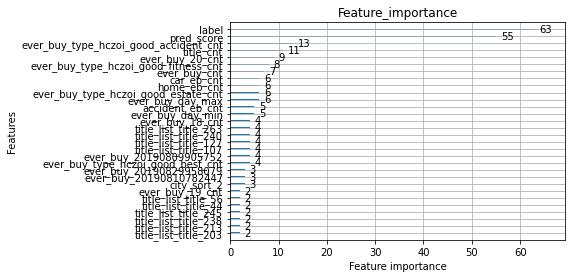

In [60]:
plt.figure(figsize=(12,6))
lgb.plot_importance(lgb_model_stack.models[1], max_num_features=30)
plt.title("Feature_importance")
plt.show()

In [56]:
split_train_true = split_train[split_train.buy==1]
split_train_true.head()

,userid,ever_buy_cnt,ever_buy_day_min,ever_buy_day_max,ever_buy_type_hczoi_good_best_cnt,ever_buy_type_hczoi_good_accident_cnt,ever_buy_type_hczoi_good_fitness_cnt,ever_buy_type_hczoi_good_trip_cnt,ever_buy_type_hczoi_good_estate_cnt,ever_buy_type_hczoi_good_company_cnt,ever_buy_type_hczoi_good_special_cnt,accident_eb_cnt,shanghai_eb_cnt,travel_eb_cnt,safe_eb_cnt,pet_eb_cnt,home_eb_cnt,child_eb_cnt,women_eb_cnt,car_eb_cnt,uaos_mode_Android,uaos_mode_iOS,nettype_mode_4G,nettype_mode_N,nettype_mode_mobile,nettype_mode_unknown,nettype_mode_wifi,nettype_cnt,uaos_cnt,title_cnt,city_sort_1,city_sort_2,city_sort_3,city_sort_4,ever_buy_20180530244125,ever_buy_20180531157314,ever_buy_20180531184230,ever_buy_20180531194127,ever_buy_20180531211243,ever_buy_20180531237016,ever_buy_20180531263676,ever_buy_20180531390867,ever_buy_20180531685516,ever_buy_20180531810706,ever_buy_20180806735689,ever_buy_20181010361410,ever_buy_20181106538615,ever_buy_20181106547495,ever_buy_20190115978886,ever_buy_20190222546822,ever_buy_20190327894840,ever_buy_20190327990852,ever_buy_20190423119297,ever_buy_20190508189069,ever_buy_20190809905752,ever_buy_20190810782447,ever_buy_20190815675296,ever_buy_20190815856774,ever_buy_20190829850245,ever_buy_20190829958079,ever_buy_20191114199289,ever_buy_20191120721521,ever_buy_20191121595608,ever_buy_20191126774471,ever_buy_20191129999329,ever_buy_20191224890793,ever_buy_20191231160884,ever_buy_2019123176289,ever_buy_2020010375676,ever_buy_20200210696720,ever_buy_20200210741736,ever_buy_20200218174314,ever_buy_20200219418368,ever_buy_20200220160007,ever_buy_2020022175979,ever_buy_2020022815278,ever_buy_20200301318382,ever_buy_20200301448260,ever_buy_20200301801446,ever_buy_20200304394802,ever_buy_20200309387999,ever_buy_20200316644689,ever_buy_2020031948380,ever_buy_20200327987123,ever_buy_20200403495571,ever_buy_20200407795677,ever_buy_20200407796159,nettype_list_2_75G_EDGE,nettype_list_2G,nettype_list_3_5G_HSDPA,nettype_list_3G,nettype_list_4G,nettype_list_N,nettype_list_mobile,nettype_list_no_network,nettype_list_unknown,nettype_list_wifi,uaos_list_Android,uaos_list_iOS,title_list_title_0,title_list_title_10,title_list_title_102,title_list_title_108,title_list_title_112,title_list_title_114,title_list_title_115,title_list_title_119,title_list_title_121,title_list_title_126,title_list_title_129,title_list_title_137,title_list_title_138,title_list_title_139,title_list_title_14,title_list_title_140,title_list_title_142,title_list_title_145,title_list_title_147,title_list_title_15,title_list_title_154,title_list_title_156,title_list_title_159,title_list_title_160,title_list_title_161,title_list_title_162,title_list_title_167,title_list_title_17,title_list_title_170,title_list_title_172,title_list_title_173,title_list_title_18,title_list_title_181,title_list_title_187,title_list_title_19,title_list_title_191,title_list_title_193,title_list_title_197,title_list_title_198,title_list_title_20,title_list_title_203,title_list_title_204,title_list_title_205,title_list_title_210,title_list_title_212,title_list_title_213,title_list_title_214,title_list_title_215,title_list_title_217,title_list_title_218,title_list_title_22,title_list_title_221,title_list_title_223,title_list_title_224,title_list_title_227,title_list_title_23,title_list_title_230,title_list_title_231,title_list_title_233,title_list_title_234,title_list_title_237,title_list_title_242,title_list_title_243,title_list_title_246,title_list_title_247,title_list_title_249,title_list_title_251,title_list_title_253,title_list_title_256,title_list_title_258,title_list_title_259,title_list_title_260,title_list_title_262,title_list_title_264,title_list_title_265,title_list_title_267,title_list_title_269,title_list_title_270,title_list_title_271,title_list_title_273,title_list_title_276,title_list_title_277,title_list_title_279,title_list_title_281,title_list_title_283,title_list_title_290,title_list_title_291,title_list_title_293,title_list_title_296,title_list_title_297,t

In [57]:
origin_label = split_train_true[['userid','label']].groupby(['userid'])['label'].unique().reset_index()
origin_label.head()

,userid,label
0,18403,[2]
1,19823,"[0, 7]"
2,21802,[14]
3,23707,"[2, 15]"
4,24329,"[11, 8, 16]"


In [58]:
split_train['pred_score'] = lgb_model.oof_pred

In [59]:
train_top3 = split_train[['userid','label','pred_score']].groupby("userid", group_keys=False).apply(lambda g: g.nlargest(3, "pred_score")).reset_index(drop=True)
# train_top3.head()
train_pred = train_top3.groupby(['userid'])['label'].unique().reset_index()
train_pred.head()

,userid,label
0,18403,"[0, 15, 5]"
1,19823,"[0, 15, 5]"
2,21802,"[0, 5, 15]"
3,23707,"[0, 8, 5]"
4,24329,"[0, 3, 8]"


In [60]:
def calc_score(y_true, y_pred):
    y_true['pred'] = y_pred['label']
    y_true['hits'] = y_true.apply(lambda x: len(set(x['label'])&set(x['pred'])),axis=1)
    y_true['rate'] = y_true.apply(lambda x: x['hits']/min(len(x['label']),3),axis=1)
    return y_true
    # return np.mean(y_true['rate'])
    # return np.mean(rate_list)
train_score_df = calc_score(origin_label, train_pred)

In [61]:
# train_score_df
np.mean(train_score_df['rate'])

0.395521665456306

In [62]:
product_test['pred_score'] = lgb_model.y_pred
test_top3 = product_test[['userid','label','pred_score']].groupby("userid", group_keys=False).apply(lambda g: g.nlargest(3, "pred_score")).reset_index(drop=True)
test_top3.head()

,userid,label,pred_score
0,25863,0,0.908571
1,25863,3,0.840021
2,25863,8,0.801850
3,27379,0,0.882534
4,27379,5,0.824207


In [63]:
test_top3

,userid,label,pred_score
0,25863,0,0.908571
1,25863,3,0.840021
2,25863,8,0.801850
3,27379,0,0.882534
4,27379,5,0.824207
...,...,...,...
14137,133878861,5,0.817624
14138,133878861,15,0.800659
14139,133884569,0,0.804672
14140,133884569,5,0.795589


In [64]:
test_top3['label'] = test_top3['label'].apply(lambda x:decode_product_id[num2class[x]])

In [65]:
tid_pred = test_top3.groupby(['userid'])['label'].unique().reset_index()
sumbit = pd.DataFrame({'userid':tid_pred['userid']})
pred_df = pd.DataFrame(list(tid_pred['label'].values),columns=['pred1','pred2','pred3'])
sumbit = pd.concat([sumbit, pred_df], axis=1)
sumbit.head()

,userid,pred1,pred2,pred3
0,25863,20200407796159,20200309387999,2020010375676
1,27379,20200407796159,20200301448260,20181010361410
2,28060,20200407796159,20200301448260,20181010361410
3,30799,20200407796159,20200301448260,20181010361410
4,30960,20200407796159,20200309387999,2020010375676


In [66]:
sumbit.head()

,userid,pred1,pred2,pred3
0,25863,20200407796159,20200309387999,2020010375676
1,27379,20200407796159,20200301448260,20181010361410
2,28060,20200407796159,20200301448260,20181010361410
3,30799,20200407796159,20200301448260,20181010361410
4,30960,20200407796159,20200309387999,2020010375676


In [67]:
len(sumbit)

4714

In [68]:
pred_path = 'pred/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)
sumbit.to_csv('pred/submit_title.csv',sep=',',index=False)

In [72]:
!wget -nv -O kesci_submit https://cdn.kesci.com/submit_tool/v4/kesci_submit&&chmod +x kesci_submit

wget: /opt/conda/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /opt/conda/lib/libssl.so.1.0.0: no version information available (required by wget)
wget: /opt/conda/lib/libssl.so.1.0.0: no version information available (required by wget)
2020-06-13 08:29:26 URL:https://cdn.kesci.com/submit_tool/v4/kesci_submit [7357446/7357446] -> "kesci_submit" [1]


In [73]:
!./kesci_submit -token a8d553a5d7c58c41 -file /home/kesci/pred/submit_feat_cnt.csv

Kesci Submit Tool 4.0.0

> 已验证Token
> 提交文件 /home/kesci/pred/submit_feat_cnt.csv (248.57 KiB), Target Qiniu
> 已上传 100 %
> 文件已上传        
> 服务器响应: 200 提交成功，请等待评审完成
> 提交完成


In [ ]:
# init_points = 16
# n_iter = 16
# bounds_LGB = {
#     'max_depth': (10, 14),
#     'lambda_l1': (0, 10),
#     'lambda_l2': (0, 10),
#     'bagging_fraction': (0.7, 1),
#     'bagging_freq': (1, 10),
#     'colsample_bytree': (0.7, 1),
#     'learning_rate': (0.06, 0.24)
# }

# LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=1030)

# with warnings.catch_warnings():
#     warnings.filterwarnings('ignore')
#     LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
# params = {
#     'boosting_type': 'gbdt',
#     'metric': 'auc',
#     'objective': 'binary',
#     'eval_metric': 'auc',
#     'n_jobs': -1,
#     'seed': 42,
#     'early_stopping_rounds': 150,
#     'n_estimators': 2000,
#     'learning_rate': LGB_BO.max['params']['learning_rate'],
#     'max_depth': int(LGB_BO.max['params']['max_depth']),
#     'lambda_l1': LGB_BO.max['params']['lambda_l1'],
#     'lambda_l2': LGB_BO.max['params']['lambda_l2'],
#     'bagging_fraction': LGB_BO.max['params']['bagging_fraction'],
#     'bagging_freq': int(LGB_BO.max['params']['bagging_freq']),
#     'colsample_bytree': LGB_BO.max['params']['colsample_bytree'],
#     'verbose': 100
# }
# params

In [ ]:
# for idx, uids in enumerate(lgb_model.userid_splits):
#     print(f'{idx}-fold userid split')
#     split_train_true_fold = split_train_true[split_train_true.userid.isin(uids)]
#     # print(split_train_true_fold.columns)
#     sttfgb = split_train_true_fold.groupby('userid')
#     lens = list(sttfgb.apply(len))
#     uid_feat = sttfgb.head(1)
#     sample_ratio = 1
#     sample_list = np.array(sample_ratio*(len(unique_label) - np.array(lens)),dtype=np.int)
#     repeat_dict_neg = {x:np.repeat(uid_feat[x], sample_list) for x in ['userid']+feat_cols}
#     split_train_neg = pd.DataFrame(repeat_dict_neg)
#     label_neg = []
#     for idx, l in enumerate(lens):
#         print(sttfgb['label'].unique())
#         # choice_list = [x for x in unique_label if x not in ]
#         # label_neg.extend(choice_list)
#     # split_train_neg['label'] = label_neg
#     # split_train_neg['buy'] = len(label_neg)*[0]
#     # split_train_neg = split_train_neg.reset_index(drop=True)

#     # print(uid_feat.head())
#     if idx==0:
#         break
    

In [ ]:
class Lgb_Model_multiclass(Base_Model):
    def train_model(self, train_set, val_set):
        verbosity = 20 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self, num_class):
        params = {'boosting_type': 'gbdt',
                 'metric': 'multi_logloss',
                 'objective': 'multiclass',
                 'eval_metric': 'multi_logloss',
                 'n_jobs': -1,
                 'num_class': num_class,
                 'seed': 42,
                 'early_stopping_rounds': 300,
                 'n_estimators': 5000,
                 'learning_rate': 0.06286444196736185,
                 'max_depth': 14,
                 'lambda_l1': 9.333246325767785,
                 'lambda_l2': 6.920781745815084,
                 'bagging_fraction': 0.9544433397522463,
                 'bagging_freq': 2,
                 'colsample_bytree': 0.7031796450809756,
                 'is_unbalance':True,
                 'verbose': 20}
        return params

In [ ]:
# below no use!!!!!!!!!!!

In [109]:
# unique_label = train_encode_title
num_class = len(unique_label)
class2num = {unique_label[i]:i for i in range(num_class)}
num2class = {i:unique_label[i] for i in range(num_class)}
label_origin = split_train['label']
split_train['label'] = split_train['label'].apply(lambda x: class2num[x])
lgb_model = Lgb_Model_multiclass(split_train, reduce_test, split_train['label'], features=feat_cols, num_class=num_class)
test_pred, lgb_models, train_pred = lgb_model.fit()

In [110]:
train_pred.shape

In [111]:
split_train['label'].shape

In [112]:
reduce_train_label = reduce_train['label'].apply(lambda x: [class2num[i] for i in x])

In [113]:
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform(reduce_train_label)
# mlb_label = pd.DataFrame(mlb_result, columns=list(mlb.classes_))
# mlb_label.head()
# print(len(mlb_label.columns))
mlb_result

In [114]:
mlb.classes_

In [115]:
label_group = list(lens)
cnt=0
flag_group = []
idx = 0 
train_pred_merge = []
for l in label_group:
    train_pred_merge.append(np.mean(train_pred[idx:idx+l],axis=0))
    idx = idx + l
train_pred_merge = np.array(train_pred_merge)
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(mlb_result, train_pred_merge, average='micro')
print("auc_score:", auc_score)

In [116]:
train_pm = train_pred_merge.argsort(axis=1)[:,::-1][:,:3]

In [117]:
def calc_score(y_true_mlb, y_pred):
    rate_list = []
    for idx, row in enumerate(y_true_mlb):
        cnt = 0 
        for p in y_pred[idx]:
            if row[p]==1:
                cnt+=1
        rate = cnt/min(len(row),3)
        rate_list.append(rate)
    return np.mean(rate_list)
calc_score(mlb_result, train_pm)

CNN

In [ ]:
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

filter_length = 300

model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
#model.add(Dropout(0.5))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)
]

history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

In [86]:
test_pred.shape

In [87]:
pred_top3 = test_pred.argsort(axis=1)[:,::-1][:,:3]
pred_top3

In [88]:
pred_top3_df = pd.DataFrame(pred_top3)
pred_cols = ['pred1', 'pred2', 'pred3']
pred_top3_df.columns = pred_cols
pred_top3_df.head()
def decode_pred(data, col):
    data[col] = data[col].apply(lambda x:decode_product_id[num2class[x]])
    return data
for pcol in pred_cols:
    pred_top3_df = decode_pred(pred_top3_df, pcol)
pred_top3_df.head()

In [89]:
submit = reduce_test['userid']
submit = pd.concat([submit, pred_top3_df], axis=1)
submit.head()

In [91]:
pred_path = r'/home/kesci/pred/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)
submit.to_csv(r'/home/kesci/pred/submit2.csv',sep=',',index=False)

In [92]:
!wget -nv -O kesci_submit https://cdn.kesci.com/submit_tool/v4/kesci_submit&&chmod +x kesci_submit

In [93]:
!./kesci_submit -token a8d553a5d7c58c41 -file /home/kesci/pred/submit2.csv